# Biostat 257 Homework 2

### Yixuan Zhou (UID 505 524 487)

**Due Apr 29 @ 11:59PM**

In [1]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake)


In [2]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, Random

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

In [3]:
function nnmf(
    X       :: Matrix{T}, 
    r       :: Integer; 
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: Matrix{T} = rand(T, size(X, 1), r), 
    W       :: Matrix{T} = rand(T, r, size(X, 2)),
    verbose :: Bool = false
    ) where T <: AbstractFloat

    n, m = size(X)
    
    niter = maxiter
    storageR = Matrix{T}(undef, r, r)
    storageV1 = similar(V)
    storageV2 = similar(V)
    storageW1 = similar(W)
    storageW2 = similar(W)

    # set up initial obj
    x2norm = norm(X)^2
    obj = x2norm 
    mul!(storageR, transpose(V), V)
    mul!(storageW2, storageR, W)
    mul!(storageW1, transpose(V), X)
    @inbounds for idx in eachindex(W)
        obj = obj + (storageW2[idx] - 2storageW1[idx]) * W[idx]
    end
    
    if verbose
        println("iter = 0, obj = $obj")
    end

    for iter in 1:maxiter

        mul!(storageR, W, transpose(W)) 
        mul!(storageV2, V, storageR)
        mul!(storageV1, X, transpose(W))
        V .= V .* storageV1 ./ storageV2
        
        mul!(storageR, transpose(V), V)
        mul!(storageW2, storageR, W)
        mul!(storageW1, transpose(V), X)
        
        objold = obj
        obj = x2norm 
        @inbounds for idx in eachindex(W)
            obj = obj + (storageW2[idx] - 2storageW1[idx]) * W[idx]
            W[idx] = W[idx] * storageW1[idx] / storageW2[idx]
        end 
    
        if verbose
            println("iter = $iter, obj = $obj")
        end
        if abs(obj - objold) ≤ tolfun * (abs(objold) + 1) 
            niter = iter
            break
        end     
    end
    
    if niter == maxiter
        # @warning "maxiter reached without convergence"
        @warn "SCREAM!!!! maxiter reached without convergence"
    end 

    V, W, obj, niter
end

nnmf (generic function with 1 method)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

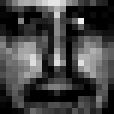

In [4]:
X = readdlm("nnmf-2429-by-361-face.txt")
V0full = readdlm("V0.txt")
W0full = readdlm("W0.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

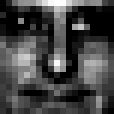

In [5]:
colorview(Gray, reshape(X[5, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    @time V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  1.047598 seconds (20 allocations: 6.904 MiB)
obj=11730.38800985483, niter=239
r=20
  1.913147 seconds (20 allocations: 7.120 MiB)
obj=8497.222317850326, niter=394
r=30
  2.434662 seconds (20 allocations: 7.336 MiB)
obj=6621.627345486279, niter=482
r=40
  3.424469 seconds (22 allocations: 7.554 MiB)
obj=5256.663870563529, niter=581
r=50
  4.480342 seconds (23 allocations: 7.774 MiB)
obj=4430.201581697291, niter=698
```
Since my laptop is about 6-7 years old, I expect to see your run time shorter than mine. Your memory allocation should be less or equal to mine.

**Solution**

In [6]:
# run the function once to compile it
r = 10
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
nnmf(X, r; V = V0, W = W0)

([0.11851552506050547 0.029940503455096936 … 0.0028830808553836898 0.064209910487126; 0.13176807592569614 0.0004309168162359835 … 0.01486343136309386 0.035028745583671625; … ; 0.052705837558246364 0.04794098005164004 … 0.1700196278798265 0.04626182097825301; 0.12933014679416066 0.01956781040212816 … 0.09435983264067124 0.029580777291877237], [3.385885235846894e-27 1.1745375738681033e-27 … 0.23001933337975108 2.2801686250908547e-6; 0.01089979057338704 1.7007366080212261e-6 … 9.165787020781076e-15 5.134415347265328e-11; … ; 4.0722852963975666e-10 0.00011974641917548936 … 6.611383816440941e-6 1.3798984047397109e-12; 5.698509363463677e-10 6.980500700786396e-9 … 2.2318529440909026e-14 1.8764490698063125e-18], 11730.86690575003, 239)

In [7]:
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    @time V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
end

r=10
  0.420252 seconds (2.66 k allocations: 591.181 KiB, 2.92% compilation time)
obj=11730.86690575003, niter=239
r=20
  0.764594 seconds (22 allocations: 875.891 KiB)
obj=8497.605595865596, niter=394
r=30
  1.058854 seconds (22 allocations: 1.285 MiB)
obj=6621.945968477781, niter=482
r=40
  1.470157 seconds (24 allocations: 1.716 MiB)
obj=5256.866299832117, niter=581
r=50
  2.437973 seconds (25 allocations: 2.149 MiB)
obj=4430.362097313581, niter=698


### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

**Solution**

No, the answer from choosing different starting $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$ gives different objective values and $(\mathbf{V}, \mathbf{W})$. Since it is a numerical search based on the objective function, the result might prematurely stop on a plateau of the objective function without reaching the global minimum. 

In [8]:
r = 10
V02 = V0full[:, 11:(10+r)]
W02 = W0full[11:(10+r), :]
nnmf(X, r, V = V02, W = W02)

([0.15639140668990062 0.0015110046893658383 … 0.017505157138830274 6.743421135235227e-7; 0.183437502753449 0.0037040562063363897 … 0.03490943487859234 2.1259645340095597e-7; … ; 0.0433991260771574 0.03806544167018934 … 0.06941835850668024 0.020544893336734323; 0.1319224118079186 1.4722228394706425e-30 … 0.007155803405155358 0.1131608643995278], [1.9486373647887635e-27 2.9049023385036153e-34 … 0.0029521015712268795 1.5754888954917352e-22; 0.5194953000146963 0.4305190756940345 … 1.4638347637819606 1.447771181275669; … ; 1.2028562561079277 1.6800376244622715 … 1.0694524520983362e-9 1.6219022752604946e-16; 4.515031596988584e-20 1.5741529561407076e-12 … 1.7708254500572091 1.4174803801837539], 11589.359173554183, 293)

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

**Solution**

No, we do not obtain the same objective value and $(\mathbf{V}, \mathbf{W})$. By comparing the objective values at the end of the algorithm with the previous examples, we see a much larger objective value from specifying all 1's for the starting matrices. This might suggest that the algorithm is trapped at a location without finding a much better minimum objective value. 

In [9]:
r = 10
m, n = size(X) 
V03 = ones(m, r)
W03 = ones(r, n)
nnmf(X, r, V = V03, W = W03)

([0.02737339344273953 0.02737339344273953 … 0.027373393442739525 0.027373393442739525; 0.027206938610572086 0.027206938610572086 … 0.027206938610572096 0.027206938610572096; … ; 0.028520195404725113 0.028520195404725113 … 0.028520195404725116 0.028520195404725116; 0.02803092551508475 0.02803092551508475 … 0.028030925515084758 0.028030925515084758], [0.36995177994768597 0.46065860110694035 … 0.5580793952009436 0.4255210382434648; 0.36995177994768597 0.46065860110694035 … 0.5580793952009436 0.4255210382434648; … ; 0.36995177994768613 0.46065860110694046 … 0.5580793952009441 0.42552103824346466; 0.36995177994768613 0.46065860110694046 … 0.5580793952009441 0.42552103824346466], 25297.015778490062, 4)

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

**Solution**

The basis images of W are the blurred versions of X. 

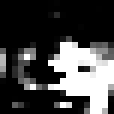

In [10]:
r = 50
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
result = nnmf(X, r, V = V0, W = W0)
colorview(Gray, reshape(result[2][1, :], 19, 19))

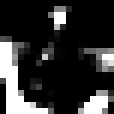

In [11]:
colorview(Gray, reshape(result[2][5, :], 19, 19))

### Q1.7 GPU (optional)

Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

## Q2. Estimating Kinship Matrix

Consider the numerical task of estimating an $n \times n$ kinship matrix $\Phi$ from an $n \times m$ genotype matrix $\mathbf{G}$. Here $n$ is the number of individuals and $m$ is the number of genetic markers. [Lange et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6763373/) derived a method of moment estimator of form
$$
    \widehat \Phi_{ij} = \frac{e_{ij} - \sum_{k=1}^m [p_k^2 + (1 - p_k)^2]}{m - \sum_{k=1}^m [p_k^2 + (1 - p_k)^2]}, \quad 1 \le i, j \le n,
$$
where
$$
\begin{eqnarray*}
    e_{ij} &=& \frac{1}{4} \sum_{k=1}^m [g_{ik} g_{jk} + (2 - g_{ik})(2 - g_{jk})] \\
    p_k &=& \frac {1}{2n} \sum_{i=1}^n g_{ik}.
\end{eqnarray*}
$$

### Q2.1 Develop code

Write a function that takes a matrix `G` as input and outputs the method of moment estimator. 
Make your function as efficient (both speed and memory) as possible.    

**Solution**

In [12]:
function kinship(G::Matrix{T}) where T <: AbstractFloat
    n, m = size(G)

    Φ = zeros(n, n)
    S = zeros(n)
    
    sum!(S, G)
    mul!(Φ, G, G')
    denom = 2 / n * sum(S) - 1 / n^2 * sum(Φ)
    
    Φ .= Φ ./ denom .+ 1
    
    for i = 1:n, j = 1:n
        Φ[i, j] =  Φ[i, j] - (S[i] + S[j])/ denom
    end
    # output
    Φ
end

kinship (generic function with 1 method)

### Q2.2 Correctness

First let's make sure our function yields correct answer. Run your function on a fake genotype matrix

Compare the upper left $5 \times 5$ block to what I got using my implementation

```julia
Φ[1:5, 1:5]
```

```
5×5 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   0.00343992   0.00293959
 -0.000762864   0.665178     -0.0101691   -0.0110697    0.00223912
 -0.00266412   -0.0101691     0.665078     0.0102444    0.00253932
  0.00343992   -0.0110697     0.0102444    0.66768     -0.0083679
  0.00293959    0.00223912    0.00253932  -0.0083679    0.663777
```

**Solution**

The answer matches with the expected result.

In [13]:
# generate a fake genotype matrix with entries {0, 1, 2}
Random.seed!(257)
G = rand(0.0:2.0, 1000, 10000)
Φ = kinship(G)
Φ[1:5, 1:5]

5×5 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   0.00343992   0.00293959
 -0.000762864   0.665178     -0.0101691   -0.0110697    0.00223912
 -0.00266412   -0.0101691     0.665078     0.0102444    0.00253932
  0.00343992   -0.0110697     0.0102444    0.66768     -0.0083679
  0.00293959    0.00223912    0.00253932  -0.0083679    0.663777

### Q2.3 Efficiency

In a typical genetic data set, $n$ is at order of $10^3 \sim 10^6$ and $m$ is at order of $10^6 \sim 10^7$. Benchmark your function using the smaller data set $G$ generated in Q2.2. Efficiency (both speed and memory) will be the most important criterion when grading this question.

**Hint**: I got `@btime` output
```
82.144 ms (3 allocations: 7.64 MiB)
```

**Solution**

The result matches with the expected efficiency. 

In [14]:
# benchmark
@btime kinship($G)

  83.541 ms (3 allocations: 7.64 MiB)


1000×1000 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   …   0.0108448    -0.00446532
 -0.000762864   0.665178     -0.0101691        0.00994423   -0.00136326
 -0.00266412   -0.0101691     0.665078        -0.0157728    -0.00356472
  0.00343992   -0.0110697     0.0102444        0.0106447     0.00514105
  0.00293959    0.00223912    0.00253932      -0.00506571    0.00163873
 -0.00226386   -0.00626651   -0.00876817   …   0.00834317    0.00494091
  0.00684217   -0.00516578    0.00384018      -0.00486558    0.00604164
  0.00404032    0.00524111   -0.00816777      -0.00236392   -0.00696697
  0.000237799   0.00233919    0.0129462       -0.0012632    -0.00296432
  0.00564138   -0.00366479    0.0108448       -0.00736724    0.0154479
  0.00574144   -0.00606638    0.00203899   …   0.00273946   -0.00736724
 -0.00326452   -0.00856803   -0.000162467      0.00183886   -0.0089683
  0.000638064   0.00293959   -0.00306439      -0.00496565   -0.00156339
  ⋮                                    